___
# Home Credit Default Risk - Feature Engineering
___

Popular consensus is that feature engineering will be essential part of this competition. Many thanks to [Will Koehrsen](https://www.kaggle.com/willkoehrsen) for sharing his works. I've learned great deal from his Kernals. I followed his code as a guide to feature engineering this project. 

## <a id='index'>Index</a>
### <a id='section1' href='#1'>Section 1: Data</a>
<a href='#1.1'>1.1 Get the Data</a>

<a href='#1.2'>1.2 Plan of Attack</a>

### <a id='section2' href='#2'>Section 2: Manual Feature Engineering</a>
<a href='#2.1'>2.1 Aggregation Functions </a>

<a href='#2.2'>2.2 Convert Data Types</a>

<a href='#2.3'>2.3 bureau.csv</a>

<a href='#2.4'>2.4 bureau_balance.csv</a>

<a href='#2.5'>2.5 previous_application.csv</a>

<a href='#2.6'>2.6 POS_CASH_balance.csv</a>

<a href='#2.7'>2.7 credit_card_balance.csv</a>

<a href='#2.8'>2.8 installments_payments.csv</a>

### <a id='section3' href='#3'>Section 3: Feature Selection</a>
<a href='#3.1'>3.1 Label Encoding </a>

<a href='#3.2'>3.2 Value 365423</a>

<a href='#3.3'>3.3 Missing Values</a>

<a href='#3.4'>3.4 Collinearity</a>

<a href='#3.5'>3.5 Feature Importance</a>

### <a id='section4' href='#4'>Section 4: Prediction and Submission</a>
<a href='#4.1'>4.1 Median Imputation and Scaling </a>

<a href='#4.2'>4.2 Training the Model</a>

<a href='#4.3'>4.3 Prediction and Feature Importance</a>

<a href='#4.4'>4.4 Submission</a>

## <a id='1' href='#section1'>Section 1: Relational Data</a>

There were total 7 dataset given in this competition (excluding test set). 

All the data are linked by UID of user. (SK_ID_CURR, SK_ID_BUREAU, or SK_ID_PREV)

Below is the relational data schema. 

![home_credit.png](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

### <a id='1.1' href='#section1'>1.1 Get the Data</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# load train and test data
app_train = pd.read_csv('../input/Home Credit Default Risk/application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True)
app_test = pd.read_csv('../input/Home Credit Default Risk/application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True)

**Join the train and test data**

In [3]:
# # Add identifying column
# app_train['set'] = 'train'
# app_test['set'] = 'test'
# app_test["TARGET"] = np.nan

# # Append the dataframes
# app = app_train.append(app_test, ignore_index = True, sort=False)

### <a id='1.2' href='#section1'>1.2 Plan of Attack</a>

Because I lack domain knowledge of the data (and time), I decided not to work too deeply with the dataset to create meaningful features. Instead I will aggregate all the data into train and test data.

In the end, I might have to do some sort of decomposition to reduce the number of variables to avoid overfitting. 

## <a id='2' href='#section2'>Section 2: Aggregation Functions</a>

### <a id='2.1' href='#section2'>2.1 Two Aggregation Functions</a>

Because we have to repeat similar work with 7 different dataset, define function that will help aggregating features.

One function will deal with numeric values, while the other with categorical values.

**Aggregate numeric features function**

In [4]:
def agg_numeric(df, parent_var, df_name, function = ['count', 'mean', 'max', 'min', 'sum']):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.

    Parameters
    --------
        df (dataframe):
            the child dataframe to calculate the statistics on
        parent_var (string):
            the parent variable used for grouping and aggregating
        df_name (string):
            the variable used to rename the columns

    Return
    --------
        agg (dataframe):
            a dataframe with the statistics aggregated by the `parent_var` for
            all numeric columns. Each observation of the parent variable will have
            one row in the dataframe with the parent variable as the index.
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed.

    """

    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)

    # Only want the numeric variables
    numeric_df = df.select_dtypes('number')
    numeric_df[parent_var] = df[parent_var]

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(function)

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Iterate through the stat names
        for stat in agg.columns.levels[1]:
            # Make a new column name for the variable and stat
            columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    
    # drop columns with all duplicate values
    nunique = agg.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    agg.drop(cols_to_drop, axis=1)
    
    return agg

**Count function for categorical values**

In [5]:
def count_categorical(df, group_var, df_name, function = ['mean', 'sum']):
    """
    Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(function)
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in categorical.columns.levels[1]:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # drop columns with all duplicate values
    nunique = categorical.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    categorical.drop(cols_to_drop, axis=1)
    
    return categorical

### <a id='2.2' href='#section2'>2.2 Memory</a>

This could take up a lot of memory, so I'll do following to ease the memory
1. use **Garbage Collector** module to dump used variables
2. **convert datatypes** that would reduce memory usage (ex. object to category, int64 to int32.
3. **merge to manufactured_feature dataframe** when done and dump the old data. 

In [6]:
import gc
from utils import convert_types
from utils import remove_missing_columns

### <a id='2.3' href='#section2'>2.3 bureau.csv</a>

In [7]:
bureau = pd.read_csv('../input/Home Credit Default Risk/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).set_index('SK_ID_CURR')#.loc[:1000, :]

# convert data types
bureau = convert_types(bureau, print_info=True)

# remove value 365243
bureau = bureau.replace(365243, np.nan)

print(bureau.shape)
bureau.head(5)

Original Memory Usage: 0.23 gb.
New Memory Usage: 0.14 gb.
(1716428, 16)


,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
SK_ID_CURR,,,,,,,,,,,,,,,,
100001,5896630,Closed,currency 1,-857,0,-492.0,-553.0,NaN,0,112500.0,0.0,0.0,0.0,Consumer credit,-155,0.0
100001,5896631,Closed,currency 1,-909,0,-179.0,-877.0,NaN,0,279720.0,0.0,0.0,0.0,Consumer credit,-155,0.0
100001,5896632,Closed,currency 1,-879,0,-514.0,-544.0,NaN,0,91620.0,0.0,0.0,0.0,Consumer credit,-155,0.0
100001,5896633,Closed,currency 1,-1572,0,-1329.0,-1328.0,NaN,0,85500.0,0.0,0.0,0.0,Consumer credit,-155,0.0
100001,5896634,Active,currency 1,-559,0,902.0,NaN,NaN,0,337680.0,113166.0,0.0,0.0,Consumer credit,-6,4630.5


In [8]:
bureau.reset_index(inplace = True)

# save bureau id to current id match for later use
bureau_id_to_curr_id = bureau[['SK_ID_CURR', 'SK_ID_BUREAU']]

In [9]:
# aggregated stats of numerica variables
temp_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']).reset_index(), parent_var = 'SK_ID_CURR', df_name = 'bureau')
    
# value count categorical variables
temp_count = count_categorical(bureau.reset_index(), group_var = 'SK_ID_CURR', df_name = 'bureau')

# merge two together
bureau_cleaned = temp_agg.merge(temp_count, on = 'SK_ID_CURR', how ='left')

# save
# bureau_cleaned.to_csv('bureau_cleaned.csv', index = False)

# print result
print('Aggregated',temp_agg.shape,'+ Count', temp_count.shape, '=', bureau_cleaned.shape)
bureau_cleaned.head()

C:\Users\Gabe\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Aggregated (305811, 65) + Count (305811, 46) = (305811, 111)


,bureau_index_count,bureau_index_mean,bureau_index_max,bureau_index_min,bureau_index_sum,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,...,bureau_CREDIT_TYPE_Microloan_mean,bureau_CREDIT_TYPE_Microloan_sum,bureau_CREDIT_TYPE_Mobile operator loan_mean,bureau_CREDIT_TYPE_Mobile operator loan_sum,bureau_CREDIT_TYPE_Mortgage_mean,bureau_CREDIT_TYPE_Mortgage_sum,bureau_CREDIT_TYPE_Real estate loan_mean,bureau_CREDIT_TYPE_Real estate loan_sum,bureau_CREDIT_TYPE_Unknown type of loan_mean,bureau_CREDIT_TYPE_Unknown type of loan_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,7,3.0,6,0,21,7,-735.000000,-49,-1572,-5145,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
100002,8,10.5,14,7,84,8,-874.000000,-103,-1437,-6992,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
100003,4,16.5,18,15,66,4,-1400.750000,-606,-2586,-5603,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
100004,2,19.5,20,19,39,2,-867.000000,-408,-1326,-1734,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
100005,3,22.0,23,21,66,3,-190.666667,-62,-373,-572,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0


In [10]:
# merge with train and test
app_train = app_train.merge(bureau_cleaned, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_cleaned, on = 'SK_ID_CURR', how = 'left')

# drop columns with missing data
app_train, app_test = remove_missing_columns(app_train, app_test)

There are 0 columns with greater than 90% missing values.


In [11]:
# free up memory by deleting temps
gc.enable()
del temp_agg, temp_count, bureau, bureau_cleaned
gc.collect()

147

### <a id='2.4' href='#section2'>2.4 bureau_balance.csv</a>

In [12]:
bureau_balance = pd.read_csv('../input/Home Credit Default Risk/bureau_balance.csv').sort_values(['SK_ID_BUREAU', 'MONTHS_BALANCE']).reset_index(drop = True)#.loc[:1000, :]

# convert data types
bureau_balance = convert_types(bureau_balance, print_info=True)

# remove value 365243
bureau_balance = bureau_balance.replace(365243, np.nan)

print(bureau_balance.shape)
bureau_balance.head(5)

Original Memory Usage: 0.66 gb.
New Memory Usage: 0.35 gb.
(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5001709,-96,X
1,5001709,-95,X
2,5001709,-94,X
3,5001709,-93,X
4,5001709,-92,X


bureau_balance.csv does not have SK_ID_BUREAU feature. We will have to:
1. group by SK_ID_BUREAU first
2. add SK_ID_CURR matching to SK_ID_BUREAU to the data
3. group by SK_ID_CURR

**Group by SK_ID_BUREAU**

In [13]:
# aggregated stats of numerica variables
temp_agg = agg_numeric(bureau_balance, parent_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')

# value count categorical variables
temp_count = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')

# merge two together
temp_merged = temp_agg.merge(temp_count, on = 'SK_ID_BUREAU', how ='left')

C:\Users\Gabe\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
# Merge to include the SK_ID_CURR
temp_merged = bureau_id_to_curr_id.merge(temp_merged, on = 'SK_ID_BUREAU', how = 'left')

In [15]:
temp_merged.head()

,SK_ID_CURR,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_mean,bureau_balance_STATUS_0_sum,bureau_balance_STATUS_1_mean,...,bureau_balance_STATUS_3_mean,bureau_balance_STATUS_3_sum,bureau_balance_STATUS_4_mean,bureau_balance_STATUS_4_sum,bureau_balance_STATUS_5_mean,bureau_balance_STATUS_5_sum,bureau_balance_STATUS_C_mean,bureau_balance_STATUS_C_sum,bureau_balance_STATUS_X_mean,bureau_balance_STATUS_X_sum
0,100001,5896630,29.0,-14.0,0.0,-28.0,-406.0,0.103448,3.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.655172,19.0,0.241379,7.0
1,100001,5896631,30.0,-14.5,0.0,-29.0,-435.0,0.033333,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.966667,29.0,0.000000,0.0
2,100001,5896632,29.0,-14.0,0.0,-28.0,-406.0,0.068966,2.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.620690,18.0,0.310345,9.0
3,100001,5896633,52.0,-25.5,0.0,-51.0,-1326.0,0.019231,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.846154,44.0,0.134615,7.0
4,100001,5896634,19.0,-9.0,0.0,-18.0,-171.0,0.631579,12.0,0.052632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.315789,6.0


In [16]:
# Aggregate the stats for each SK_ID_CURR
bureau_balance_cleaned = agg_numeric(temp_merged.drop(columns = ['SK_ID_BUREAU']), parent_var= 'SK_ID_CURR', df_name = 'client')

# save
# bureau_balance_cleaned.to_csv('bureau_balance_cleaned.csv', index = False)

# print result
print('=', bureau_balance_cleaned.shape)
bureau_balance_cleaned.head()

= (305811, 105)


,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,client_bureau_balance_MONTHS_BALANCE_mean_sum,...,client_bureau_balance_STATUS_X_mean_count,client_bureau_balance_STATUS_X_mean_mean,client_bureau_balance_STATUS_X_mean_max,client_bureau_balance_STATUS_X_mean_min,client_bureau_balance_STATUS_X_mean_sum,client_bureau_balance_STATUS_X_sum_count,client_bureau_balance_STATUS_X_sum_mean,client_bureau_balance_STATUS_X_sum_max,client_bureau_balance_STATUS_X_sum_min,client_bureau_balance_STATUS_X_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,7,24.571429,52.0,2.0,172.0,7,-11.785714,-0.5,-25.5,-82.5,...,7,0.214590,0.500000,0.0,1.502129,7,4.285714,9.0,0.0,30.0
100002,8,13.750000,22.0,4.0,110.0,8,-21.875000,-1.5,-39.5,-175.0,...,8,0.161932,0.500000,0.0,1.295455,8,1.875000,3.0,0.0,15.0
100003,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,...,0,NaN,NaN,NaN,0.000000,0,NaN,NaN,NaN,0.0
100004,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,...,0,NaN,NaN,NaN,0.000000,0,NaN,NaN,NaN,0.0
100005,3,7.000000,13.0,3.0,21.0,3,-3.000000,-1.0,-6.0,-9.0,...,3,0.136752,0.333333,0.0,0.410256,3,0.666667,1.0,0.0,2.0


In [17]:
# merge with train and test
app_train = app_train.merge(bureau_balance_cleaned, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_balance_cleaned, on = 'SK_ID_CURR', how = 'left')

# drop columns with missing data
app_train, app_test = remove_missing_columns(app_train, app_test)

There are 0 columns with greater than 90% missing values.


In [18]:
# free up memory by deleting temps
gc.enable()
del temp_agg, temp_count, temp_merged, bureau_balance, bureau_balance_cleaned
gc.collect()

126

### <a id='2.5' href='#section2'>2.5 previous_application.csv</a>

In [19]:
previous = pd.read_csv('../input/Home Credit Default Risk/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).set_index('SK_ID_CURR')#.loc[:1000, :]

# convert data types
previous = convert_types(previous, print_info=True)

# remove value 365243
previous = previous.replace(365243, np.nan)

print(previous.shape)
previous.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.19 gb.
(1670214, 36)


,SK_ID_PREV,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1369693,Consumer loans,3951.000000,24835.5,23787.0,2520.0,24835.5,FRIDAY,13,Y,...,Connectivity,8.0,high,POS mobile with interest,NaN,-1709.0,-1499.0,-1619.0,-1612.0,0.0
100002,1038818,Consumer loans,9251.775391,179055.0,179055.0,0.0,179055.0,SATURDAY,9,Y,...,Auto technology,24.0,low_normal,POS other with interest,NaN,-565.0,125.0,-25.0,-17.0,0.0
100003,1810518,Cash loans,98356.992188,900000.0,1035882.0,NaN,900000.0,FRIDAY,12,Y,...,XNA,12.0,low_normal,Cash X-Sell: low,NaN,-716.0,-386.0,-536.0,-527.0,1.0
100003,2396755,Consumer loans,6737.310059,68809.5,68053.5,6885.0,68809.5,SATURDAY,15,Y,...,Consumer electronics,12.0,middle,POS household with interest,NaN,-2310.0,-1980.0,-1980.0,-1976.0,1.0
100003,2636178,Consumer loans,64567.664062,337500.0,348637.5,0.0,337500.0,SUNDAY,17,Y,...,Furniture,6.0,middle,POS industry with interest,NaN,-797.0,-647.0,-647.0,-639.0,0.0


In [20]:
# aggregated stats of numerica variables
temp_agg = agg_numeric(previous.drop(columns = ['SK_ID_PREV']).reset_index(), parent_var = 'SK_ID_CURR', df_name = 'previous')

# value count categorical variables
temp_count = count_categorical(previous.reset_index(), group_var = 'SK_ID_CURR', df_name = 'previous')

# merge two together
previous_cleaned = temp_agg.merge(temp_count, on = 'SK_ID_CURR', how ='left')

# save
# previous_cleaned.to_csv('previous_cleaned.csv', index = False)

# print result
print('Aggregated',temp_agg.shape,'+ Count', temp_count.shape, '=', previous_cleaned.shape)
previous_cleaned.head()

C:\Users\Gabe\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Aggregated (338857, 90) + Count (338857, 286) = (338857, 376)


,previous_AMT_ANNUITY_count,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_sum,previous_AMT_APPLICATION_count,previous_AMT_APPLICATION_mean,previous_AMT_APPLICATION_max,previous_AMT_APPLICATION_min,previous_AMT_APPLICATION_sum,...,previous_PRODUCT_COMBINATION_POS industry without interest_mean,previous_PRODUCT_COMBINATION_POS industry without interest_sum,previous_PRODUCT_COMBINATION_POS mobile with interest_mean,previous_PRODUCT_COMBINATION_POS mobile with interest_sum,previous_PRODUCT_COMBINATION_POS mobile without interest_mean,previous_PRODUCT_COMBINATION_POS mobile without interest_sum,previous_PRODUCT_COMBINATION_POS other with interest_mean,previous_PRODUCT_COMBINATION_POS other with interest_sum,previous_PRODUCT_COMBINATION_POS others without interest_mean,previous_PRODUCT_COMBINATION_POS others without interest_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1,3951.000000,3951.000000,3951.000000,3951.000000,1,24835.50,24835.5,24835.5,24835.5,...,0.0,0,1.0,1,0.0,0,0.0,0,0.0,0
100002,1,9251.775391,9251.775391,9251.775391,9251.775391,1,179055.00,179055.0,179055.0,179055.0,...,0.0,0,0.0,0,0.0,0,1.0,1,0.0,0
100003,3,56553.988281,98356.992188,6737.310059,169661.968750,3,435436.50,900000.0,68809.5,1306309.5,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
100004,1,5357.250000,5357.250000,5357.250000,5357.250000,1,24282.00,24282.0,24282.0,24282.0,...,0.0,0,0.0,0,1.0,1,0.0,0,0.0,0
100005,1,4813.200195,4813.200195,4813.200195,4813.200195,2,22308.75,44617.5,0.0,44617.5,...,0.0,0,0.5,1,0.0,0,0.0,0,0.0,0


In [21]:
# merge with train and test
app_train = app_train.merge(previous_cleaned, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_cleaned, on = 'SK_ID_CURR', how = 'left')

# drop columns with missing data
app_train, app_test = remove_missing_columns(app_train, app_test)

There are 6 columns with greater than 90% missing values.


In [22]:
# free up memory by deleting temps
gc.enable()
del temp_agg, temp_count, previous, previous_cleaned
gc.collect()

112

### <a id='2.6' href='#section2'>2.6 POS_CASH_balance.csv</a>

In [23]:
cash = pd.read_csv('../input/Home Credit Default Risk/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).set_index('SK_ID_CURR')#.loc[:1000, :]

# convert data types
cash = convert_types(cash, print_info=True)

# remove value 365243
cash = cash.replace(365243, np.nan)

cash.reset_index(inplace=True)

print(cash.shape)
cash.head()

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.45 gb.
(10001358, 8)


,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,100001,1369693,-53,4.0,0.0,Completed,0,0
1,100001,1369693,-54,4.0,1.0,Active,0,0
2,100001,1369693,-57,4.0,4.0,Active,0,0
3,100001,1369693,-55,4.0,2.0,Active,0,0
4,100001,1369693,-56,4.0,3.0,Active,0,0


In [24]:
# aggregated stats of numerica variables
temp_agg = agg_numeric(cash.drop(columns = ['SK_ID_PREV']), parent_var = 'SK_ID_CURR', df_name = 'cash')

# value count categorical variables
temp_count = count_categorical(cash, group_var = 'SK_ID_CURR', df_name = 'cash')

# merge two together
cash_cleaned = temp_agg.merge(temp_count, on = 'SK_ID_CURR', how ='left')

# print result
print('Aggregated',temp_agg.shape,'+ Count', temp_count.shape, '=', cash_cleaned.shape)
cash_cleaned.head()

# save
# cash_cleaned.to_csv('cash_cleaned.csv', index = False)

C:\Users\Gabe\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Aggregated (337252, 25) + Count (337252, 18) = (337252, 43)


,cash_MONTHS_BALANCE_count,cash_MONTHS_BALANCE_mean,cash_MONTHS_BALANCE_max,cash_MONTHS_BALANCE_min,cash_MONTHS_BALANCE_sum,cash_CNT_INSTALMENT_count,cash_CNT_INSTALMENT_mean,cash_CNT_INSTALMENT_max,cash_CNT_INSTALMENT_min,cash_CNT_INSTALMENT_sum,...,cash_NAME_CONTRACT_STATUS_Completed_mean,cash_NAME_CONTRACT_STATUS_Completed_sum,cash_NAME_CONTRACT_STATUS_Demand_mean,cash_NAME_CONTRACT_STATUS_Demand_sum,cash_NAME_CONTRACT_STATUS_Returned to the store_mean,cash_NAME_CONTRACT_STATUS_Returned to the store_sum,cash_NAME_CONTRACT_STATUS_Signed_mean,cash_NAME_CONTRACT_STATUS_Signed_sum,cash_NAME_CONTRACT_STATUS_XNA_mean,cash_NAME_CONTRACT_STATUS_XNA_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,9,-72.555556,-53,-96,-653,9,4.000000,4.0,4.0,36.0,...,0.222222,2,0.0,0,0.0,0,0.000000,0,0.0,0
100002,19,-10.000000,-1,-19,-190,19,24.000000,24.0,24.0,456.0,...,0.000000,0,0.0,0,0.0,0,0.000000,0,0.0,0
100003,28,-43.785714,-18,-77,-1226,28,10.107142,12.0,6.0,283.0,...,0.071429,2,0.0,0,0.0,0,0.000000,0,0.0,0
100004,4,-25.500000,-24,-27,-102,4,3.750000,4.0,3.0,15.0,...,0.250000,1,0.0,0,0.0,0,0.000000,0,0.0,0
100005,11,-20.000000,-15,-25,-220,10,11.700000,12.0,9.0,117.0,...,0.090909,1,0.0,0,0.0,0,0.090909,1,0.0,0


In [25]:
# merge with train and test
app_train = app_train.merge(cash_cleaned, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(cash_cleaned, on = 'SK_ID_CURR', how = 'left')

# drop columns with missing data
app_train, app_test = remove_missing_columns(app_train, app_test)

There are 0 columns with greater than 90% missing values.


In [26]:
# free up memory by deleting temps
gc.enable()
del temp_agg, temp_count, cash, cash_cleaned
gc.collect()

112

### <a id='2.7' href='#section2'>2.7 credit_card_balance.csv</a>

In [27]:
credit = pd.read_csv('../input/Home Credit Default Risk/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).set_index('SK_ID_CURR')#.loc[:1000, :]

# convert data types
credit = convert_types(credit, print_info=True)

# remove value 365243
credit = credit.replace(365243, np.nan)

credit.reset_index(inplace = True)

print(credit.shape)
credit.head()

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.43 gb.
(3840312, 23)


,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,100006,1489396,-2,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
1,100006,1489396,-1,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
2,100006,1489396,-5,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
3,100006,1489396,-3,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
4,100006,1489396,-4,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0


In [28]:
# aggregated stats of numerica variables
temp_agg = agg_numeric(credit.drop(columns = ['SK_ID_PREV']), parent_var = 'SK_ID_CURR', df_name = 'credit')

# value count categorical variables
temp_count = count_categorical(credit, group_var = 'SK_ID_CURR', df_name = 'credit')

# merge two together
credit_cleaned = temp_agg.merge(temp_count, on = 'SK_ID_CURR', how ='left')

# print result
print('Aggregated',temp_agg.shape,'+ Count', temp_count.shape, '=', credit_cleaned.shape)
credit_cleaned.head()

# save
# credit_cleaned.to_csv('credit_cleaned.csv', index = False)

C:\Users\Gabe\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Aggregated (103558, 100) + Count (103558, 14) = (103558, 114)


,credit_MONTHS_BALANCE_count,credit_MONTHS_BALANCE_mean,credit_MONTHS_BALANCE_max,credit_MONTHS_BALANCE_min,credit_MONTHS_BALANCE_sum,credit_AMT_BALANCE_count,credit_AMT_BALANCE_mean,credit_AMT_BALANCE_max,credit_AMT_BALANCE_min,credit_AMT_BALANCE_sum,...,credit_NAME_CONTRACT_STATUS_Completed_mean,credit_NAME_CONTRACT_STATUS_Completed_sum,credit_NAME_CONTRACT_STATUS_Demand_mean,credit_NAME_CONTRACT_STATUS_Demand_sum,credit_NAME_CONTRACT_STATUS_Refused_mean,credit_NAME_CONTRACT_STATUS_Refused_sum,credit_NAME_CONTRACT_STATUS_Sent proposal_mean,credit_NAME_CONTRACT_STATUS_Sent proposal_sum,credit_NAME_CONTRACT_STATUS_Signed_mean,credit_NAME_CONTRACT_STATUS_Signed_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,6,-3.5,-1,-6,-21,6,0.000000,0.00000,0.0,0.00,...,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0
100011,74,-38.5,-2,-75,-2849,74,54482.109375,189000.00000,0.0,4031676.25,...,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0
100013,96,-48.5,-1,-96,-4656,96,18159.919922,161420.21875,0.0,1743352.25,...,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0
100021,17,-10.0,-2,-18,-170,17,0.000000,0.00000,0.0,0.00,...,0.588235,10,0.0,0,0.0,0,0.0,0,0.0,0
100023,8,-7.5,-4,-11,-60,8,0.000000,0.00000,0.0,0.00,...,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0


In [29]:
# merge with train and test
app_train = app_train.merge(credit_cleaned, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(credit_cleaned, on = 'SK_ID_CURR', how = 'left')

# drop columns with missing data
app_train, app_test = remove_missing_columns(app_train, app_test)

There are 0 columns with greater than 90% missing values.


In [30]:
# free up memory by deleting temps
gc.enable()
del temp_agg, temp_count, credit, credit_cleaned
gc.collect()

112

### <a id='2.8' href='#section2'>2.8 installments_payments.csv</a>

In [31]:
installments = pd.read_csv('../input/Home Credit Default Risk/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER']).set_index('SK_ID_CURR')#.loc[:1000, :]

# convert data types
installments = convert_types(installments, print_info=True)

# remove value 365243
installments = installments.replace(365243, np.nan)

installments.reset_index(inplace=True)

print(installments.shape)
installments.head()

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.54 gb.
(13605401, 8)


,SK_ID_CURR,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,100001,1369693,1.0,1,-1709.0,-1715.0,3951.000000,3951.000000
1,100001,1369693,1.0,2,-1679.0,-1715.0,3951.000000,3951.000000
2,100001,1369693,1.0,3,-1649.0,-1660.0,3951.000000,3951.000000
3,100001,1369693,2.0,4,-1619.0,-1628.0,17397.900391,17397.900391
4,100001,1851984,1.0,2,-2916.0,-2916.0,3982.050049,3982.050049


In [32]:
# for this, I'll create a new value, 
    # AMT_INSTALMENT	What was the prescribed installment amount of previous credit on this installment
    # AMT_PAYMENT	What the client actually paid on previous credit on this installment

# calculate the difference
installments['AMT_PAID_DIFF'] = installments['AMT_PAYMENT'] - installments['AMT_INSTALMENT']

# indicator for not meeting prescribe installment amount
installments['PAID_IN_FULL'] = installments['AMT_PAID_DIFF'].apply(lambda x: 1 if x < 0 else 0 )

In [33]:
# doesn't have categorical values

# aggregated stats of numerica variables
installments_cleaned = agg_numeric(installments.drop(columns = ['SK_ID_PREV']), parent_var = 'SK_ID_CURR', df_name = 'installments')

# print result
print('=', installments_cleaned.shape)
installments_cleaned.head()

# save
# installments.to_csv('installments.csv', index = False)

= (339587, 40)


,installments_NUM_INSTALMENT_VERSION_count,installments_NUM_INSTALMENT_VERSION_mean,installments_NUM_INSTALMENT_VERSION_max,installments_NUM_INSTALMENT_VERSION_min,installments_NUM_INSTALMENT_VERSION_sum,installments_NUM_INSTALMENT_NUMBER_count,installments_NUM_INSTALMENT_NUMBER_mean,installments_NUM_INSTALMENT_NUMBER_max,installments_NUM_INSTALMENT_NUMBER_min,installments_NUM_INSTALMENT_NUMBER_sum,...,installments_AMT_PAID_DIFF_count,installments_AMT_PAID_DIFF_mean,installments_AMT_PAID_DIFF_max,installments_AMT_PAID_DIFF_min,installments_AMT_PAID_DIFF_sum,installments_PAID_IN_FULL_count,installments_PAID_IN_FULL_mean,installments_PAID_IN_FULL_max,installments_PAID_IN_FULL_min,installments_PAID_IN_FULL_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,7,1.142857,2.0,1.0,8.0,7,2.714286,4,1,19,...,7,0.0,0.0,0.0,0.0,7,0.0,0,0,0
100002,19,1.052632,2.0,1.0,20.0,19,10.000000,19,1,190,...,19,0.0,0.0,0.0,0.0,19,0.0,0,0,0
100003,25,1.040000,2.0,1.0,26.0,25,5.080000,12,1,127,...,25,0.0,0.0,0.0,0.0,25,0.0,0,0,0
100004,3,1.333333,2.0,1.0,4.0,3,2.000000,3,1,6,...,3,0.0,0.0,0.0,0.0,3,0.0,0,0,0
100005,9,1.111111,2.0,1.0,10.0,9,5.000000,9,1,45,...,9,0.0,0.0,0.0,0.0,9,0.0,0,0,0


In [34]:
# merge with train and test
app_train = app_train.merge(installments_cleaned, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(installments_cleaned, on = 'SK_ID_CURR', how = 'left')

# drop columns with missing data
app_train, app_test = remove_missing_columns(app_train, app_test)

There are 0 columns with greater than 90% missing values.


In [35]:
# free up memory by deleting temps
gc.enable()
del installments, installments_cleaned
gc.collect()

84

### <a id='2.9' href='#section2'>2.9 Manually Feature Engineered Data</a>

In [36]:
print('Train Data:\t', app_train.shape, '\nTest Data:\t',app_test.shape)

Train Data:	 (307511, 905) 
Test Data:	 (48744, 904)


In [40]:
# Save the app_with_manufcatured_features DF
app_train.to_csv('train_with_manufactured_features.csv', index = False)
app_test.to_csv('test_with_manufactured_features.csv', index = False)

In [ ]:
# load app_train
# app_train = pd.read_csv('train_with_manufactured_features.csv')
# app_test = pd.read_csv('test_with_manufactured_features.csv')

## <a id='3' href='#section3'>Section 3: Feature Selection</a>

So we made bunch of new features, but a lot of them are probably important. (hopefully not)

Also to avoid overfitting and curse of dimensionality, let's drop seemingly meaningless features.

### <a id='3.1' href='#section3'>3.1 Label Encoding</a>

In [41]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Train Data:\t', app_train.shape, '\nTest Data:\t',app_test.shape)
app_train.head()

Train Data:	 (307511, 1029) 
Test Data:	 (48744, 1025)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0,0,0,0,0,0


In [42]:
train_labels = app_train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

print('Train Data:\t',app_train.shape, '\nTest Data:\t',app_test.shape,  '\nTrain Label:\t',train_labels.shape)

Train Data:	 (307511, 1025) 
Test Data:	 (48744, 1025) 
Train Label:	 (307511,)


### <a id='3.2' href='#section3'>3.2 Remove Value 365,243</a>

Replace value 354243 with NaN

In [43]:
app_train.set_index('SK_ID_CURR')
app_test.set_index('SK_ID_CURR')

# remove value 365243
app_train = app_train.replace(365243, np.nan)
app_test = app_test.replace(365243, np.nan)

* Note: this process could improve. 365243 implies something about the feature. (for example, the client is not working). If we could capture the meaning, it could improve the model. 

### <a id='3.3' href='#section3'>3.3 Missing Values</a>

** From Old code | this is kept to double check for missing value **

We could rid of features with majority of values missing.

In [44]:
from utils import missing_values_table

threshold = 75

# use one of my function from my utility
missing_value_table = missing_values_table(app_train)

missing_value_table.head(20)

Your selected dataframe has 1025 columns.
There are 846 columns that have missing values.


,Missing Values,% of Total Values
previous_DAYS_FIRST_DRAWING_min,254159,82.7
previous_DAYS_FIRST_DRAWING_max,254159,82.7
previous_DAYS_FIRST_DRAWING_mean,254159,82.7
credit_AMT_PAYMENT_CURRENT_min,246451,80.1
credit_AMT_PAYMENT_CURRENT_mean,246451,80.1
credit_AMT_PAYMENT_CURRENT_max,246451,80.1
credit_CNT_DRAWINGS_POS_CURRENT_mean,246371,80.1
credit_AMT_DRAWINGS_POS_CURRENT_min,246371,80.1
credit_CNT_DRAWINGS_ATM_CURRENT_min,246371,80.1
credit_CNT_DRAWINGS_OTHER_CURRENT_mean,246371,80.1


In [45]:
missing_features = missing_value_table[missing_value_table['% of Total Values'] >= threshold]

print('Number of columns with more than', threshold,'% missing values: ', len(missing_features))

Number of columns with more than 75 % missing values:  24


**Drop columns**

In [46]:
app_train = app_train.drop(columns=missing_features.index)
app_test = app_test.drop(columns=missing_features.index)

print('Train Data:\t', app_train.shape, '\nTest Data:\t',app_test.shape)

Train Data:	 (307511, 1001) 
Test Data:	 (48744, 1001)


### <a id='3.4' href='#section3'>3.4 Collinear Variables</a>


In [47]:
# absolute value correlation matrix
corr_matrix = app_train.corr()
corr_matrix.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,1.000000,-0.001128,-0.001819,-0.000344,-0.000438,-0.000233,0.000847,-0.001497,-0.000087,-0.000974,...,0.000553,0.002073,-0.000976,0.000072,-0.001396,0.002295,-0.001279,-0.000269,0.000507,0.002549
CNT_CHILDREN,-0.001128,1.000000,0.012882,0.002145,0.021374,-0.001827,-0.025573,0.330938,0.061145,0.183395,...,-0.001830,-0.005272,-0.000709,0.001607,-0.002032,-0.020892,-0.025088,0.011036,-0.038644,0.004525
AMT_INCOME_TOTAL,-0.001819,0.012882,1.000000,0.156870,0.191657,0.159610,0.074796,0.027261,-0.013005,0.027805,...,0.000718,0.011696,0.006149,0.023886,0.003886,0.032753,0.016523,-0.003369,0.050174,-0.002894
AMT_CREDIT,-0.000344,0.002145,0.156870,1.000000,0.770138,0.986968,0.099738,-0.055436,-0.091295,0.009621,...,0.000869,0.014314,0.007987,0.027255,0.005799,0.046644,0.009756,-0.007373,0.058256,-0.004308
AMT_ANNUITY,-0.000438,0.021374,0.191657,0.770138,1.000000,0.775109,0.118429,0.009445,-0.053604,0.038514,...,0.002166,0.015589,0.010077,0.035318,0.005968,0.054988,0.009189,-0.007711,0.068145,-0.003910


In [48]:
threshold = 0.90

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,NaN,-0.001128,-0.001819,-0.000344,-0.000438,-0.000233,0.000847,-0.001497,-0.000087,-0.000974,...,0.000553,0.002073,-0.000976,0.000072,-0.001396,0.002295,-0.001279,-0.000269,0.000507,0.002549
CNT_CHILDREN,NaN,NaN,0.012882,0.002145,0.021374,-0.001827,-0.025573,0.330938,0.061145,0.183395,...,-0.001830,-0.005272,-0.000709,0.001607,-0.002032,-0.020892,-0.025088,0.011036,-0.038644,0.004525
AMT_INCOME_TOTAL,NaN,NaN,NaN,0.156870,0.191657,0.159610,0.074796,0.027261,-0.013005,0.027805,...,0.000718,0.011696,0.006149,0.023886,0.003886,0.032753,0.016523,-0.003369,0.050174,-0.002894
AMT_CREDIT,NaN,NaN,NaN,NaN,0.770138,0.986968,0.099738,-0.055436,-0.091295,0.009621,...,0.000869,0.014314,0.007987,0.027255,0.005799,0.046644,0.009756,-0.007373,0.058256,-0.004308
AMT_ANNUITY,NaN,NaN,NaN,NaN,NaN,0.775109,0.118429,0.009445,-0.053604,0.038514,...,0.002166,0.015589,0.010077,0.035318,0.005968,0.054988,0.009189,-0.007711,0.068145,-0.003910


In [49]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('The number of columns with collinearity higher than ', threshold * 100, '%: ', len(to_drop))

The number of columns with collinearity higher than  90.0 %:  245


**Drop columns**

In [50]:
app_train = app_train.drop(columns=to_drop)
app_test = app_test.drop(columns=to_drop)

print('Train Data:\t', app_train.shape, '\nTest Data:\t',app_test.shape)

Train Data:	 (307511, 756) 
Test Data:	 (48744, 756)


### <a id='3.5' href='#section3'>3.5 Feature Importance</a>

* Use Graident Boosted Model from the LightGBM library to access feature importances
* drop features with 0 importance or very low importance.

In [51]:
import lightgbm as lgb

# Initialize an empty array to hold feature importances
feature_importances = np.zeros(app_train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [52]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(app_train, train_labels, test_size = 0.33, random_state = 929)

# Train using early stopping
model.fit(train_x, train_y, early_stopping_rounds=100, eval_set = [(valid_x, valid_y)], eval_metric = 'auc', verbose = 200)

# Record the feature importances
feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.779588
Early stopping, best iteration is:
[137]	valid_0's auc: 0.780518


In [53]:
# get feature importances
feature_importances = feature_importances
feature_importances = pd.DataFrame({'feature': list(app_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
26,EXT_SOURCE_1,160.0
27,EXT_SOURCE_2,137.0
28,EXT_SOURCE_3,107.0
7,DAYS_EMPLOYED,80.0
3,AMT_CREDIT,77.0


In [54]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 342 features with 0.0 importance


,feature,importance
206,client_bureau_balance_STATUS_5_mean_max,0.0
471,previous_NAME_SELLER_INDUSTRY_Auto technology_sum,0.0
470,previous_NAME_SELLER_INDUSTRY_Auto technology_...,0.0
469,previous_CHANNEL_TYPE_Stone_sum,0.0
755,EMERGENCYSTATE_MODE_Yes,0.0


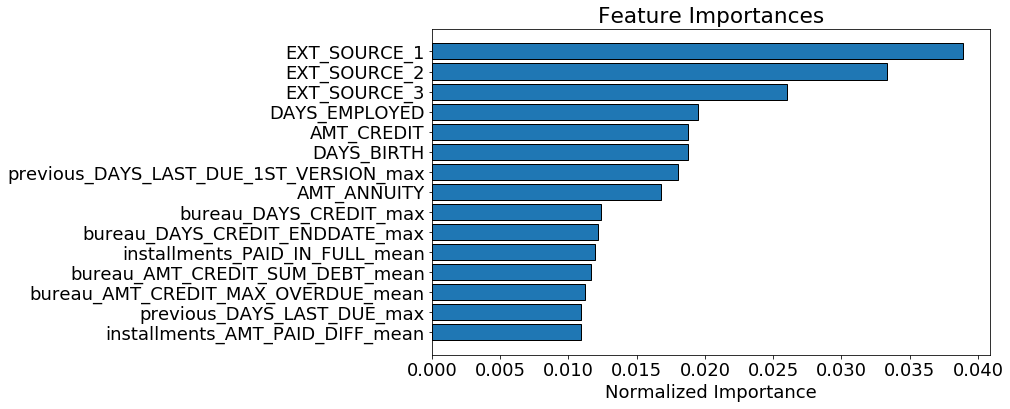

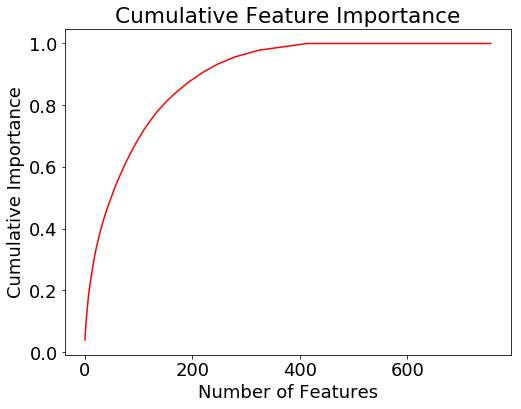

215 features required for 0.90 of cumulative importance


In [55]:
from utils import plot_feature_importances

norm_feature_importances = plot_feature_importances(feature_importances)

**Drop zero importance features**

In [56]:
app_train = app_train.drop(columns = zero_features)
app_test = app_test.drop(columns = zero_features)

print('Train Data:\t', app_train.shape, '\nTest Data:\t',app_test.shape)

Train Data:	 (307511, 414) 
Test Data:	 (48744, 414)


### <a id='3.6' href='#section3'>3.6 Repeat Feature Importance</a>

* Repeat the process to identify if there's new zero importance features.
* This would also help double check

In [57]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(app_train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

# Split data
train_x, valid_x, train_y, valid_y = train_test_split(app_train, train_labels, test_size = 0.33, random_state = 929)

# Train using early stopping
model.fit(train_x, train_y, early_stopping_rounds=100, eval_set = [(valid_x, valid_y)], eval_metric = 'auc', verbose = 200)

# Record the feature importances
feature_importances += model.feature_importances_

# get feature importances
feature_importances = feature_importances
feature_importances = pd.DataFrame({'feature': list(app_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))

app_train = app_train.drop(columns = zero_features)
app_test = app_test.drop(columns = zero_features)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.779425
Early stopping, best iteration is:
[159]	valid_0's auc: 0.780706
There are 0 features with 0.0 importance


In [58]:
# free up memory by deleting temps
gc.enable()
del  model, train_x, valid_x, train_y, valid_y
gc.collect()

5587

## <a id='4' href='#section4'>Section 4: Random Forest</a>

Now we have our features, let's try making a prediction.

We will use the same model as baseline model (RFM) to observe the progress.

In [64]:
test_id = app_test['SK_ID_CURR']
train_features = app_train.drop('SK_ID_CURR', axis = 1)
test_features = app_test.drop('SK_ID_CURR', axis = 1)

# get the overview
print('Training Feature Shape: ', app_train.shape)
print('Training Label Shape: ', train_labels.shape)
print('Testing Data Shape: ', app_test.shape)

Training Feature Shape:  (307511, 414)
Training Label Shape:  (307511,)
Testing Data Shape:  (48744, 414)


### <a id='4.1' href='#section4'>4.1 Median Imputation and Scaling</a>

In [65]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train_features = train_features.drop(columns = ['TARGET'])

# Feature names
features = list(train_features.columns)

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train_features)

# Transform both training and testing data
train_features = imputer.transform(train_features)
test_features = imputer.transform(test_features)

# Repeat with the scaler
scaler.fit(train_features)
train = scaler.transform(train_features)
test = scaler.transform(test_features)

### <a id='4.2' href='#section4'>4.2 Training the Model</a>

In [67]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_leaf=20, max_features=0.2, random_state=929)

rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=929, verbose=0, warm_start=False)

### <a id='4.3' href='#index'>4.3 Prediction and Feature Importance</a>

In [68]:
# get feature importances
feature_importance_values = rf.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})
feature_importances.set_index('feature', inplace=True)

# Make predictions on the test data
predictions = rf.predict_proba(test_features)[:, 1]

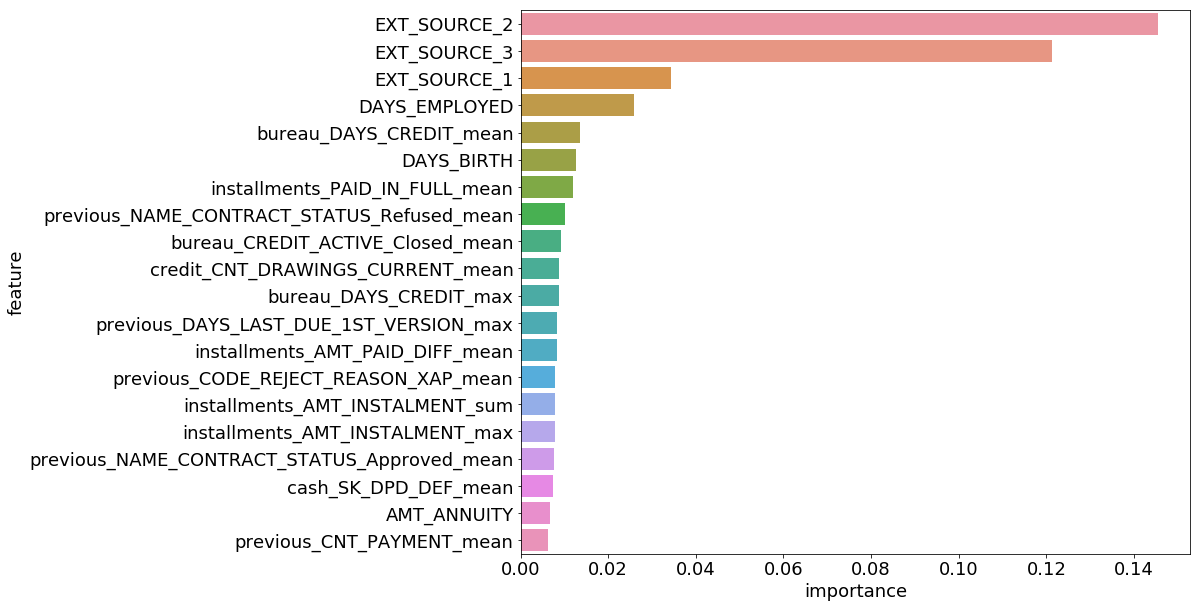

In [82]:
feature_importances.sort_values(by='importance', axis = 0, ascending=False, inplace=True)

plt.figure(figsize = (12, 10))
plt.tight_layout()

sns.barplot(x='importance', y=feature_importances.index[0:20], data=feature_importances[0:20])

### <a id='4.4' href='#section4'>4.5 Submission</a>

In [70]:
# Make the submission dataframe
submission = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': predictions})

submission.to_csv('20180823_submission.csv', index = False)

#### Result
* Scored **0.747** on Public Leaderboard. 
* Previous score before feature engineering was 0.731.
* Possible improvements:
    * Try different models (LightGBM would be an easy & effective implementation)
    * Try auto feature engineering. (Never tried this, I might try when I have time)